In [1]:
%matplotlib inline
from IPython.display import clear_output

import gc
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras import initializers
import sys
sys.path.append('/home/art/Programming/artlibs')
from artiom_convenience_functions import * 
from videorecorder import save_to_video, execute_at_exit



In [2]:
def s(img):
    plt.imshow(
    img.reshape(
    N_DIM, N_DIM), cmap='gray')

In [3]:
N_DIM = 64
faces = np.fromfile(f"girls_img_{N_DIM}x{N_DIM}.bin", dtype="uint8").reshape(-1, N_DIM * N_DIM) / 255

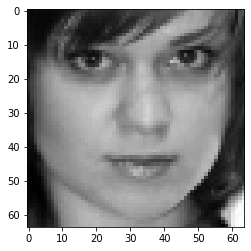

In [4]:
s(faces[2])

# Face generator

In [5]:
inputs = keras.Input(shape=(100))
x = Dense(100, activation='elu')(inputs)
#x = Dropout(0.2)(x)
x = Dense(1000, activation='sigmoid')(x)
x = Dropout(0.5)(x)
outputs = Dense(N_DIM ** 2, activation='sigmoid')(x)
face_gen = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

face_gen.compile(

    optimizer=keras.optimizers.Adam(0.00001),
    metrics=["accuracy"],
)


# policeman 

In [6]:
inputs = keras.Input(shape=(N_DIM ** 2))
x = Dropout(0.5)(inputs)
x = Dense(1000, activation='sigmoid')(x)
x = Dropout(0.5)(x)
x = Dense(1000, activation='sigmoid')(x)

outputs = Dense(1, activation='sigmoid')(x)
policeman = keras.Model(inputs=inputs, outputs=outputs, name="policeman")

In [7]:

policeman.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(0.00001),
    metrics=["accuracy"],
)

# Среда

In [8]:
policeman.trainable = False
inputs = keras.Input(shape=(100))
x = face_gen(inputs)
outputs = policeman(x) 
env_model = keras.Model(inputs=inputs, outputs=outputs, name="face_generator")

In [9]:

env_model.compile( loss="binary_crossentropy" 
)

In [10]:
env_model.summary()

Model: "face_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 face_generator (Functional)  (None, 4096)             4211196   
                                                                 
 policeman (Functional)      (None, 1)                 5099001   
                                                                 
Total params: 9,310,197
Trainable params: 4,211,196
Non-trainable params: 5,099,001
_________________________________________________________________


1/1 [==============================] - 1s 1s/step


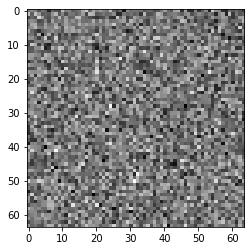

In [11]:
s(
    face_gen.predict(
        np.random.random(size=100).astype("float32").reshape(1, 100)
    ).reshape(N_DIM, N_DIM))

# Учим полицейского

In [12]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

In [13]:
faces_drawn_from_seeds = face_gen.predict(seeds)

10/10 [==============================] - 0s 1ms/step


In [14]:

indices = np.random.randint(0, len(faces), size=N)
real_faces = faces[indices]

In [15]:
X = np.concatenate([faces_drawn_from_seeds, real_faces])
X.shape

(628, 4096)

In [16]:
Y = np.zeros(
N * 2)

Y[N:] = 1

In [17]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

1.0


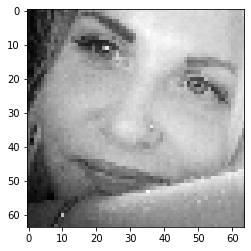

In [18]:
x, y = X[ind:=np.random.randint(0, len(X))],   Y[ind]
print(y)
s(x)

In [19]:
policeman.fit(X, Y, epochs=1, shuffle=1)
policeman.evaluate(X, Y)

20/20 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.4904


[0.6817229986190796, 0.4904458522796631]

# Теперь запускаем срелу

In [20]:
N = 314
seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

ones = np.ones(len(seeds), dtype="float32").reshape(-1, 1)


In [21]:
ones.shape

(314, 1)

In [22]:

seeds[0]

array([0.44181612, 0.7127398 , 0.26054418, 0.01984465, 0.01397809,
       0.63411796, 0.6267745 , 0.31213796, 0.8985819 , 0.41607022,
       0.55907714, 0.6446441 , 0.99633074, 0.88713837, 0.36050534,
       0.90859836, 0.8767443 , 0.18645954, 0.34626365, 0.3282072 ,
       0.82533807, 0.61136466, 0.6492427 , 0.03125165, 0.5613146 ,
       0.84077036, 0.9692536 , 0.01830305, 0.06029749, 0.22557442,
       0.4843474 , 0.9769876 , 0.18643458, 0.9992788 , 0.4609476 ,
       0.42597744, 0.8026319 , 0.85791016, 0.63831645, 0.75006455,
       0.2673411 , 0.79818755, 0.3198133 , 0.20773482, 0.01913967,
       0.11891915, 0.51778436, 0.84774923, 0.43001696, 0.403268  ,
       0.04103134, 0.63478804, 0.5311129 , 0.7315936 , 0.46733698,
       0.8003342 , 0.15909141, 0.02179836, 0.3353422 , 0.52264315,
       0.7585421 , 0.16632521, 0.8350554 , 0.43534553, 0.01785964,
       0.73188066, 0.8958743 , 0.5618813 , 0.91806316, 0.12432701,
       0.42339048, 0.12592687, 0.7828393 , 0.83488077, 0.16681

In [23]:
env_model.fit(seeds, ones, shuffle=1, epochs=1)

10/10 [==============================] - 1s 5ms/step - loss: 0.2422


# В цикле

In [24]:
faces_drawn_from_seeds[0]

array([0.5040249 , 0.5336215 , 0.50518185, ..., 0.42291284, 0.6116436 ,
       0.48999828], dtype=float32)

In [25]:
from importlib import reload

from videorecorder import get_new_cv2_imshow
from videorecorder import save_to_video, execute_at_exit

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )

In [26]:

cv2.destroyAllWindows()
from importlib import reload

reload(sys.modules['videorecorder'])
reload(sys.modules['cv2'])
#from videorecorder import save_to_video, execute_at_exit
from artiom_convenience_functions import *

from videorecorder import get_new_cv2_imshow
my_imshow = get_new_cv2_imshow(cv2.imshow, video_frame_rate=1,
                                redraw_only_every_nth_frame=1,
                                #last_frame_meditation_time_sec=3,
                                #fading_out_time_sec=5)
                               )




key = None
while key not in (27,):
    N = 409
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)
    faces_drawn_from_seeds = face_gen.predict(seeds, verbose=0)

    
    
    best_ind = np.argmax(policeman.predict(faces_drawn_from_seeds, verbose=0).reshape(-1))
    my_imshow("result", uint8_normalized(cv2.cvtColor(resize(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB)))
#     save_to_video((faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
#                                interpolation=cv2.INTER_NEAREST))
    key = cv2.waitKey(1)

    indices = np.random.randint(0, len(faces), size=N)
    real_faces = faces[indices]
    X = np.concatenate([faces_drawn_from_seeds, real_faces])
    Y = np.zeros(
    N * 2)

    Y[N:] = 1


    policeman.fit(X, Y, epochs=59, shuffle=1, verbose=0)
    policeman.evaluate(X, Y, verbose=0)






    N = 490
    seeds = np.random.random(size=(N, 100)).astype("float32").reshape(-1, 100)

    ones = np.ones(len(seeds)).reshape(-1, 1)
    env_model.fit(seeds, ones, shuffle=1, epochs=1, verbose=0)
    
execute_at_exit()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Saving video for you! See you soon!


In [27]:
cv2.cvtColor(resize(faces_drawn_from_seeds[best_ind].reshape(N_DIM, N_DIM), width=500,
                               interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB)

array([[[0.46611425, 0.46611425, 0.46611425],
        [0.46611425, 0.46611425, 0.46611425],
        [0.46611425, 0.46611425, 0.46611425],
        ...,
        [0.4552625 , 0.4552625 , 0.4552625 ],
        [0.4552625 , 0.4552625 , 0.4552625 ],
        [0.4552625 , 0.4552625 , 0.4552625 ]],

       [[0.46611425, 0.46611425, 0.46611425],
        [0.46611425, 0.46611425, 0.46611425],
        [0.46611425, 0.46611425, 0.46611425],
        ...,
        [0.4552625 , 0.4552625 , 0.4552625 ],
        [0.4552625 , 0.4552625 , 0.4552625 ],
        [0.4552625 , 0.4552625 , 0.4552625 ]],

       [[0.46611425, 0.46611425, 0.46611425],
        [0.46611425, 0.46611425, 0.46611425],
        [0.46611425, 0.46611425, 0.46611425],
        ...,
        [0.4552625 , 0.4552625 , 0.4552625 ],
        [0.4552625 , 0.4552625 , 0.4552625 ],
        [0.4552625 , 0.4552625 , 0.4552625 ]],

       ...,

       [[0.47523788, 0.47523788, 0.47523788],
        [0.47523788, 0.47523788, 0.47523788],
        [0.47523788, 0